This file is compose by following sections:
* Extract patches from MNIST dataset original images and save the extracted patches to file
* Load extracted patches from google drive file and do the training
* Automation of the test and evaluation

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans


import numpy as np
import matplotlib.pyplot as plt
from math import ceil

Extract pactches:
* Download MNIST dataset to local environment
* Read all images and filter out blank ones
* Extract patches and normalize extracted patches
* Save to .pt file

In [14]:
# Download MNISTdataset to local environment
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./MNIST_data/', download=True, train = True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = MNIST(root='./MNIST_data/', download = True, train = False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# The following section is for smail size prototyping test use only
# subset_indices = list(range(1000))
# partial_dataset = Subset(train_dataset, subset_indices)
# partial_loader = DataLoader(partial_dataset, batch_size=1, shuffle=True)

# print(len(train_dataset), len(test_dataset))

In [15]:
# Helper functions
# Extract patches (5x5) from a single original image (28x28), original image as input required
def extract_patches(images, patch_size=5, stride=1):
    patches = images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    return patches.reshape(-1, 1, patch_size, patch_size)

# Normalize a single patch
def normalize_single_patch(input_patch):
    if input_patch.max() == input_patch.min():
        return input_patch
    else:
        return (input_patch-input_patch.min())/(input_patch.max()-input_patch.min())

# Extract patches from all images, dataset loader as input required
def extract_all_patches(train_loader):
    all_patches = []
    for image, _ in train_loader:
        patches = extract_patches(image)
        for patch in patches:
            if not (patch==0).all():
                all_patches.append(normalize_single_patch(patch))
    all_patches = torch.cat(all_patches, dim=0)
    return all_patches

# Verification function:
# Plot the original image, original image from MNIST and label required
def plot_original_image(img, label):
    img = img.squeeze()
    img_np = img.numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(img_np, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Plot 24*24 unfiltered patches (including blank patches)
def plot_patches(patches, rows=24, cols=24):
    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(patches):
                axs[i, j].imshow(patches[idx].squeeze(), cmap='gray')
                axs[i, j].axis('off')
            else:
                axs[i, j].axis('off')
    plt.show()
    # plt.savefig('test_patches.png')

**When using this section of codes, uncomment codes regarding partial_loader**

Test and Verification:
* Extract an original image from the dataset and plot
* Extract patches from the image and plot
* Filter out blank patches
* Normalize extracted patches

In [16]:
# Extract an original image and its label
for test_img, test_label in partial_loader:
    break

# Plot the original image
plot_original_image(test_img, test_label)

# Extract patches from the original image
test_patches = extract_patches(test_img)

# Plot the extracted patches
plot_patches(test_patches)

# Filter out blank patches
filtered_test_patches = []
for test_patch in test_patches:
    if not (test_patch==0).all():
        filtered_test_patches.append(test_patch)

# Normalize filtered patches
normalized_filtered_test_patches = []
for filtered_test_patch in filtered_test_patches:
    normalized_filtered_test_patches.append(filtered_test_patch)


NameError: name 'partial_loader' is not defined

**Main Function Part 1: Extract and Save Patches**

In [ ]:
all_patches = extract_all_patches(train_loader=train_loader)
torch.save(all_patches, 'mnist_patches.pt')

Load and Training with K-mean Clustering

In [2]:
# Setup Environment
import faiss

# Load previously extracted patches, saved in google drive
all_patches = torch.load('mnist_patches.pt')

# Transform patches from 5x5 to 1x25
all_patches = all_patches.view(all_patches.size()[0], -1).numpy().astype('float32')

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

ngpus = faiss.get_num_gpus()

cuda:0


Helper functions:
* Plot trained centroids

In [3]:
# Plot centroids
def plot_centroids(centroids, image_shape=(5, 5), num_col=10):
    num_row = ceil(len(centroids) / num_col)
    fig, axes = plt.subplots(num_row, num_col, figsize=(12, 1.2*num_row))
    for i in range(num_row):
        for j in range(num_col):
            idx = i * num_col + j
            if idx < len(centroids):
                axes[i, j].imshow(centroids[idx].reshape(image_shape), cmap='gray')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.show()

**Test 2 Main**

In [11]:
# Test and Verification, only used when testing with small size prototyping
test_patches = all_patches

kmeans = faiss.Kmeans(d=test_patches.shape[1], k=100, niter=20, verbose=True, gpu=True, max_points_per_centroid=10000000, nredo=1)
kmeans.train(test_patches.astype(np.float32))
centroids = kmeans.centroids


In [14]:
np.save('./results/centroids.npy', centroids)

In [16]:
loaded_centroids = np.load('./results/centroids.npy')

In [ ]:
plot_centroids(centroids=loaded_centroids)

In [9]:
test_patches = all_patches[:100]

kmeans = faiss.Kmeans(d=test_patches.shape[1], k=100, niter=20, verbose=True, gpu=True, max_points_per_centroid=10000000, nredo=1)
kmeans.train(test_patches.astype(np.float32))
centroids = kmeans.centroids

In [ ]:
plot_centroids(centroids=centroids)

In [18]:
full_patches = all_patches
for k in [100, 1000, 2000, 5000, 10000]:
    kmeans = faiss.Kmeans(d=full_patches.shape[1], k=k, niter=200, verbose=True, gpu=True, max_points_per_centroid=10000000, nredo=1)
    kmeans.train(full_patches.astype(np.float32))
    centroids = kmeans.centroids
    np.save(f'./results/centroids_{k}.npy', centroids)

**Part 2 Test and Verification**



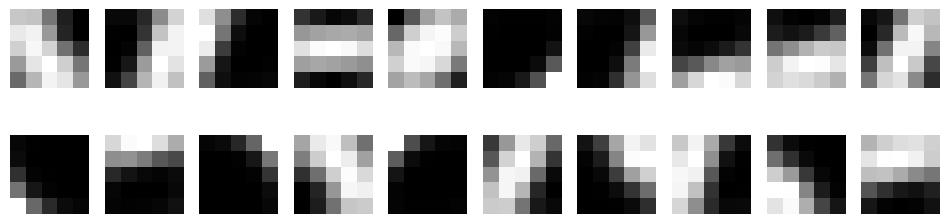

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i in range(2):
    for j in range(10):
        idx = i * 10 + j
        if idx < len(test_cluster_centers):
            axes[i,j].imshow(test_cluster_centers[idx].reshape((5,5)), cmap='gray')
            axes[i,j].axis('off')
        else:
            axes[i.j].axis('off')
plt.show()

In [ ]:
test_cluster_centers.size()

torch.Size([10, 25])

In [ ]:
test_center.view(5,5)

tensor([[6.8347e-02, 2.3839e-02, 3.4585e-03, 1.1528e-03, 1.0286e-02],
        [1.0221e-01, 2.7431e-02, 1.6469e-04, 0.0000e+00, 7.4094e-03],
        [2.4428e-01, 1.5151e-01, 6.3872e-02, 2.2500e-02, 3.0595e-02],
        [5.2810e-01, 5.0493e-01, 3.7742e-01, 2.4189e-01, 1.8437e-01],
        [8.4351e-01, 9.2882e-01, 7.9763e-01, 5.8311e-01, 4.1451e-01]])

In [ ]:
test_cluster_centers.size()

torch.Size([10, 25])

In [ ]:
x[0]

In [ ]:
ceil(17/10)

2